In [147]:
from Bio import SeqIO
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

## Data Processing

In [152]:
labelled_dataset = ProteinDataset()

In [153]:
labelled_dataset.data_df

AttributeError: 'ProteinDataset' object has no attribute 'data_df'

## Data Exploration

### Protein Groups

| Protein Group   |      Sequences      |
|----------|:-------------:|
| A |  683 |
| B |  193 |
| C | 99 |
| Other (single instances) | 22 |


### Sequences

#### Labelled
- Mean sequence length: 220.426
- Max sequence length: 422 (<512 so viable as pretrained transformer input)

#### Prediction
- Mean: 183.2
- Max: 277

Mean Sequence Length: 183.2
Max Sequence Length: 277


<AxesSubplot:xlabel='Sequence Length', ylabel='Count'>

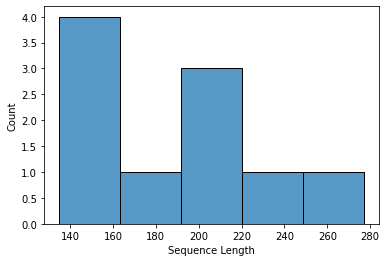

In [131]:
print(f'Mean Sequence Length: {pred_df["Sequence Length"].mean()}')
print(f'Max Sequence Length: {pred_df["Sequence Length"].max()}')
sns.histplot(pred_df['Sequence Length'])

Mean Sequence Length: 220.426
Max Sequence Length: 422


<AxesSubplot:xlabel='Sequence Length', ylabel='Count'>

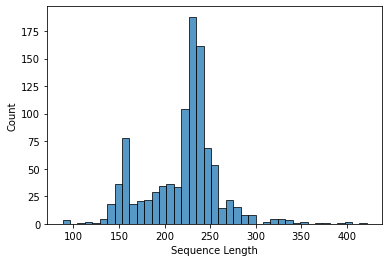

In [132]:
print(f'Mean Sequence Length: {labelled_df["Sequence Length"].mean()}')
print(f'Max Sequence Length: {labelled_df["Sequence Length"].max()}')
sns.histplot(labelled_df['Sequence Length'])

In [142]:
labelled_df['Group_ID'].value_counts()

A        683
C        193
B         99
P          2
ttttt      1
CE         1
CC         1
L          1
D          1
HHHH       1
U          1
AA         1
F          1
G          1
PT         1
IA         1
ADD        1
AD         1
M          1
II         1
LL         1
A)         1
A***8      1
AC         1
AV         1
T          1
O          1
Name: Group_ID, dtype: int64

In [146]:
train_df

,ID,Group_ID,Number_ID,Sequence Length,Sequence
834,C_035,C,035,272,"(T, G, S, G, V, V, V, D, G, A, G, Y, I, V, T, ..."
506,A_507,A,507,233,"(I, A, N, G, Q, K, A, G, T, N, E, F, P, F, M, ..."
636,A_637,A,637,223,"(I, V, G, G, Y, T, C, S, E, Y, S, V, P, Y, Q, ..."
794,B_095,B,095,192,"(G, S, G, V, I, Y, K, K, N, G, N, T, A, Y, I, ..."
989,C_190,C,190,158,"(G, S, G, V, I, I, S, S, D, G, Y, V, V, T, N, ..."
...,...,...,...,...,...
839,P_040,P,040,279,"(L, G, S, G, I, V, F, D, D, K, G, H, V, V, T, ..."
863,L_064,L,064,182,"(P, F, G, F, P, F, P, F, P, D, G, G, E, A, P, ..."
891,CC_092,CC,092,152,"(G, T, G, F, A, V, S, P, D, L, I, V, T, N, A, ..."
943,CE_144,CE,144,262,"(Q, G, C, G, V, I, I, T, P, T, G, Y, V, L, T, ..."


In [148]:
class ProteinDataset(Dataset):


    def __init__(self, raw_data: str = 'Sequences.fasta', labelled: bool = True):
        self.raw_data = raw_data
        self.labelled = labelled
        self.load_data()

        if labelled:
            self.create_dataset_split()

    def load_data(self):
        if self.labelled:
            labelled_sequences = [{
                        'ID' : i.id,
                        'Group_ID' : i.id.split('_')[0],
                        'Number_ID' : i.id.split('_')[1],
                        'Sequence Length' : len(i.seq),
                        'Sequence' : i.seq
                        }
                        for i in SeqIO.parse(self.raw_data, 'fasta')]
            print(f'Number of labelled sequences: {len(labelled_sequences)}')
            self.data_df = pd.DataFrame(labelled_sequences)
        else:
            pred_sequences = [{'ID' : i.id,
                        'Sequence Length' : len(i.seq),
                            'Sequence' : i.seq}
                            for i in SeqIO.parse('Predictions.fasta', 'fasta')]
            print(f'Number of pred sequences: {len(pred_sequences)}')
            self.data_df = pd.DataFrame(pred_sequences)

    def create_dataset_split(self):
        # Splitting dataset, any class with <3 instances added to train_df
        filtered_df = self.data_df[self.data_df['Group_ID'].isin(['A','B','C'])]
        self.train_df, self.eval_df = train_test_split(filtered_df, shuffle=True, stratify=filtered_df['Group_ID'])
        self.train_df = pd.concat([self.train_df, self.data_df[~self.data_df['Group_ID'].isin(['A','B','C'])]])


## Model

Selected pretrained model from HuggingFace.

Paper is in preprint https://arxiv.org/abs/2205.05789 [1]

Small version has 1/3 parameters of the current most popular HuggingFace model.

Given time constraints a smaller model is a big pro!

[1] RITA: a Study on Scaling Up Generative Protein Sequence Models. Hesslow et al., 2022.


In [109]:
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("lightonai/RITA_s", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("lightonai/RITA_s")

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


Downloading:   0%|          | 0.00/167 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.85k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

In [ ]:

# Tokens for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Vocab size is the number of integers 0-9
model.config.vocab_size = 10
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir="results/",
    logging_steps=2,
    save_steps=1000,
    num_train_epochs=2,
    eval_steps=200,
)
### HUGGING FACE

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
)
trainer.train()